# NAO Project: Linear Modelling in the Pooling Framework

## Package Imports

In [1]:
!pip install ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00


In [2]:
!pip install mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=77eafc6ce4c2664d81eb8197cbc949c0285179d8b0105808640c49399ca127fb
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


In [3]:
import kagglehub
from ftfy import fix_text
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mord
import re
from textblob import TextBlob
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

## Data Summary

We consider the [`skytrax-airline-reviews`](https://www.kaggle.com/datasets/efehandanisman/skytrax-airline-reviews) from Kaggle. After downloading and cleaning the data, we obtain the following cleaned data:

In [4]:
# Download latest version
path = kagglehub.dataset_download("efehandanisman/skytrax-airline-reviews")

# Define the full path to the Excel file
excel_file = os.path.join(path, "capstone_airline_reviews3.xlsx")
survey_df = pd.read_excel(excel_file)
# Dataset Duplicate Value Count
survey_df.duplicated(keep = 'first').sum()
#Dropping the Empty rows
survey_df.drop_duplicates(keep=False,inplace= True)
survey_df.reset_index(inplace=True,drop=True)
survey_df['customer_review'] = survey_df['customer_review'].apply(fix_text)
survey_df = survey_df[survey_df.isna().sum(axis=1) <= 3] # remove entries
survey_df.to_csv('capstone_airline_reviews3_cleaned.csv', index=False)
survey_df = pd.read_csv("capstone_airline_reviews3_cleaned.csv", encoding="utf-8-sig")
survey_df.head()

100%|██████████| 23.1M/23.1M [00:00<00:00, 41.4MB/s]

Extracting files...


,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,✅ Trip Verified | London to Izmir via Istanbul...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,yes
1,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,✅ Trip Verified | Istanbul to Bucharest. We ma...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,no
2,Turkish Airlines,3.0,M Galerko,7th May 2019,✅ Trip Verified | Rome to Prishtina via Istanb...,NaN,Business,Economy Class,Rome to Prishtina via Istanbul,2019-05-01 00:00:00,1.0,4.0,1.0,3.0,1.0,2.0,no
3,Turkish Airlines,10.0,Zeshan Shah,6th May 2019,✅ Trip Verified | Flew on Turkish Airlines IAD...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,April 2019,4.0,5.0,5.0,5.0,5.0,5.0,yes
4,Turkish Airlines,1.0,Pooja Jain,6th May 2019,✅ Trip Verified | Mumbai to Dublin via Istanbu...,NaN,Solo Leisure,Economy Class,Mumbai to Dublin via Istanbul,2019-05-01 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,no


#### $X$ (explanatory) variables

**Flight Information:**
- `airline`: Which airline the flight was taken (Data type: `categorical` or `text`)
- `review_data`: The date the review was taken. (Data type: `date-time`)
- `customer_review`: The contents of the review. (Data type: `text`)
- `aircraft`: The aircraft of the flight. (Data type: `categorical` or `text`)
- `traveller_type`: The type of traveller (e.g. Business, Family Leisure, Solo Leisure). (Data type: `categorical`)
- `cabin`: The class of the undertaken flight (e.g. Economy, Business and First Class). (Data type: `categorical` or `ordinal` - can possibly be considered ordinal since Economy < Business < First Class).
- `route`: The route of the flight. (Data type: `categorical`)

**Questions with Likert-Scale Responses:**
- `data_flown`: The date of the flight taken. (Data type: `date-time`)
- `seat_comfort`: Likert-scale response to a question on seat comfort. (Data type: `ordinal`)
- `cabin_service`: Likert-scale response to a question on cabin service. (Data type: `ordinal`)
- `food_bev`: Likert-scale response to a question on food/beverage quality. (Data type: `ordinal`)
- `entertainment`: Likert-scale response to a question on entertainment. (Data type: `ordinal`)
- `ground_service`: Likert-scale response to a question on ground service. (Data type: `ordinal`)
- `value_for_money`: Likert-scale response to a question on value for money. (Data type: `ordinal`)

Note that we have ignored the `author` column, since this corresponds to a unique identifier of the row (i.e. equivalent to row ID).


#### $y$ (response) variables

- `overall`: Response to overall rating of experience of flight. (Data type: `ordinal` or possibly `continuous`)
- `recommended`: Response to whether the airline would be recommended. (Data type: `categorical`)


## Questions to Answer

We are interested in how the $y$ (response) variables are influenced by the $X$ (explanatory variables). Examples of questions we would like to answer:

- Do different questions have different $y$ effects?
- Does some question's rating influence $y$ more than another question?
- Is question rating predictive in general across all questions?
- Are some questions better at discriminating $y$ responses?
- Is the effect of a question’s rating constant across subgroups (e.g., economy vs business)?

The advantage of a **Linear Model** is that all of these questions can be framed as **hypothesis tests** on the estimated regression coefficients.

## Simplifying Assumption

#### Response Variable

For the remainder of this notebook, we only consider the `recommended` variables as our single $y$ response variable.
In general, we could:

1. **Ordinal Regression:** Consider only `overall` as the response variable within an ordinal regression model.
2. **Both Response Variables:** Consider both `recommended` and `overall` together within a [General Linear Model](https://en.wikipedia.org/wiki/General_linear_model).

In [5]:
survey_df['recommended'] = survey_df['recommended'].map({'yes': 1, 'no': 0}) # do this once


#### Explanatory Variables

In addition, we drop:
 - The `customer_review` column as an $X$ (explanatory) variable, since it would have to be dealt with separately (e.g. via a text embedding like *sentiment scores* or *transformer-based embeddings*).
 - The `route` column as an explanatory variable, since there aren't many repeated routes (running `survey_df['route'].nunique()` we obtain 24028 unique items). We could infer the length of a flight from this data and use this instead.
 - The `review_date` and `date_flown` columns - just to avoid `date-time` data.
 - The 'aircraft' column - a lot of `NaN`s present.

Let's drop all these columns (including `author`):

In [6]:
survey_df = survey_df.drop(['author', 'customer_review', 'route', 'review_date', 'date_flown', 'aircraft'], axis=1)
survey_df.head()

,airline,overall,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,Turkish Airlines,7.0,Business,Economy Class,4.0,5.0,4.0,4.0,2.0,4.0,1
1,Turkish Airlines,2.0,Family Leisure,Economy Class,4.0,1.0,1.0,1.0,1.0,1.0,0
2,Turkish Airlines,3.0,Business,Economy Class,1.0,4.0,1.0,3.0,1.0,2.0,0
3,Turkish Airlines,10.0,Solo Leisure,Economy Class,4.0,5.0,5.0,5.0,5.0,5.0,1
4,Turkish Airlines,1.0,Solo Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,0


#### Dropping all NaNs

To get a clean dataset, we drop all `NaN` values from the dataset. This avoids numerical issues in the subsequent modelling steps. Alternatively, we could impute the values.

In [7]:
survey_df = survey_df.dropna()
survey_df

,airline,overall,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,Turkish Airlines,7.0,Business,Economy Class,4.0,5.0,4.0,4.0,2.0,4.0,1
1,Turkish Airlines,2.0,Family Leisure,Economy Class,4.0,1.0,1.0,1.0,1.0,1.0,0
2,Turkish Airlines,3.0,Business,Economy Class,1.0,4.0,1.0,3.0,1.0,2.0,0
3,Turkish Airlines,10.0,Solo Leisure,Economy Class,4.0,5.0,5.0,5.0,5.0,5.0,1
4,Turkish Airlines,1.0,Solo Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
34265,Ukraine International,1.0,Family Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,0
34266,Ukraine International,1.0,Family Leisure,Economy Class,1.0,2.0,1.0,1.0,1.0,1.0,0
34268,Ukraine International,10.0,Couple Leisure,Economy Class,5.0,5.0,5.0,4.0,4.0,4.0,1
34269,Ukraine International,2.0,Solo Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,0


#### Modelling Assumption

Since our response variable is the binary column `recommended`, we model it using *logistic regression*. Specifically, we assume:

$$
Y \mid X = x \sim \mathrm{Bernoulli}(\mathrm{logit}^{-1}(f(x))),
$$

where $f(x)$ is a linear model of the covariates.


## Unpooled Model

In the unpooled model, we treat each row independently and include all explanatory variables directly in the regression. We fit the following linear model for $f(x)$:

$$
f(x) = \beta^\top x,
$$

where $x$ represents a single row of the dataset, including both numerical and encoded categorical variables.

Since several explanatory variables are categorical — such as `airline`, `traveller_type`, and `cabin` — we expand them using indicator variables. The full logistic regression model becomes:

$$
\text{logit}(\Pr(Y \mid X = x)) = \beta_0
+ \sum_{i=1}^{n_a} \alpha_i \, \mathbb{1}(\text{airline} = i)
+ \sum_{i=1}^{n_t} \tau_i \, \mathbb{1}(\text{traveller\_type} = i)
+ \sum_{i=1}^{n_c} \gamma_i \, \mathbb{1}(\text{cabin} = i)
+ \sum_{j=1}^{6} \beta_j \, x_j,
$$

where the last sum runs over the six Likert-scale variables: `seat_comfort`, `cabin_service`, `food_bev`, `entertainment`, `ground_service`, and `value_for_money`.

This can be achieved using the following code:

In [8]:
import statsmodels.formula.api as smf

model = smf.logit(
    formula="""
    recommended ~ C(airline) + C(traveller_type) + C(cabin)
        + seat_comfort + cabin_service + food_bev
        + entertainment + ground_service + value_for_money
    """,
    data=survey_df
)

result = model.fit()
print(result.summary())


         Current function value: 0.148688
         Iterations: 35


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            recommended   No. Observations:                21091
Model:                          Logit   Df Residuals:                    21004
Method:                           MLE   Df Model:                           86
Date:                Mon, 19 May 2025   Pseudo R-squ.:                  0.7853
Time:                        10:26:38   Log-Likelihood:                -3136.0
converged:                      False   LL-Null:                       -14609.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -10.1538      0.558    -18.202      0.000     -11.247      -9.060
C(airline)[T.Adria Airways]                 

Unfortunately, there is a numerical issue due to one of the airlines (`QantasLink` - with only four total flights) having all of their `recommended` values equalling $1$:

In [9]:
airline_outcome_counts = (
    survey_df
    .groupby('airline')['recommended']
    .value_counts()
    .unstack(fill_value=0)
)

print(airline_outcome_counts.sort_values(by=0))  # Sort by # of "no"s


recommended            0    1
airline                      
QantasLink             0    4
Thai Smile Airways     1   11
Germanwings            4    2
Adria Airways          4    5
Tunisair               5    5
...                  ...  ...
Emirates             491  566
Spirit Airlines      516   32
British Airways      782  475
United Airlines      987  305
American Airlines   1061  272

[75 rows x 2 columns]


To avoid, this we could either drop the whole column or remove rows who have a very small number of flights. Let's do the latter:

In [10]:
# Drop airlines with fewer than 10 rows or only one class in recommended
valid_airlines = (
    airline_outcome_counts
    [(airline_outcome_counts.sum(axis=1) >= 10) &  # enough total
     (airline_outcome_counts[0] > 0) &             # at least one "no"
     (airline_outcome_counts[1] > 0)]              # at least one "yes"
).index

survey_df = survey_df[survey_df['airline'].isin(valid_airlines)]
survey_df

,airline,overall,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,Turkish Airlines,7.0,Business,Economy Class,4.0,5.0,4.0,4.0,2.0,4.0,1
1,Turkish Airlines,2.0,Family Leisure,Economy Class,4.0,1.0,1.0,1.0,1.0,1.0,0
2,Turkish Airlines,3.0,Business,Economy Class,1.0,4.0,1.0,3.0,1.0,2.0,0
3,Turkish Airlines,10.0,Solo Leisure,Economy Class,4.0,5.0,5.0,5.0,5.0,5.0,1
4,Turkish Airlines,1.0,Solo Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
34265,Ukraine International,1.0,Family Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,0
34266,Ukraine International,1.0,Family Leisure,Economy Class,1.0,2.0,1.0,1.0,1.0,1.0,0
34268,Ukraine International,10.0,Couple Leisure,Economy Class,5.0,5.0,5.0,4.0,4.0,4.0,1
34269,Ukraine International,2.0,Solo Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,0


Rerunning the model:

In [11]:
import statsmodels.formula.api as smf

model = smf.logit(
    formula="""
    recommended ~ C(airline) + C(traveller_type) + C(cabin)
        + seat_comfort + cabin_service + food_bev
        + entertainment + ground_service + value_for_money
    """,
    data=survey_df
)

result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.148770
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            recommended   No. Observations:                21072
Model:                          Logit   Df Residuals:                    20988
Method:                           MLE   Df Model:                           83
Date:                Mon, 19 May 2025   Pseudo R-squ.:                  0.7852
Time:                        10:26:40   Log-Likelihood:                -3134.9
converged:                       True   LL-Null:                       -14596.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -10.1501

### Evaluating Unpooled Approach: Likert-Scale Variables Only

Due to the large number of different airlines, let's just drop everything apart from the Likert Scale questions. So, our model is:

$$
\text{logit}(\Pr(Y \mid X = x)) = \beta_0  + \sum_{j=1}^{6} \beta_j \, x_j.
$$


In [12]:
cleaned_df = survey_df.drop(['airline', 'traveller_type', 'cabin'], axis=1)
cleaned_df

,overall,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,7.0,4.0,5.0,4.0,4.0,2.0,4.0,1
1,2.0,4.0,1.0,1.0,1.0,1.0,1.0,0
2,3.0,1.0,4.0,1.0,3.0,1.0,2.0,0
3,10.0,4.0,5.0,5.0,5.0,5.0,5.0,1
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...
34265,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
34266,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0
34268,10.0,5.0,5.0,5.0,4.0,4.0,4.0,1
34269,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0


In [13]:
import statsmodels.formula.api as smf

model = smf.logit(
    formula="""
    recommended ~  seat_comfort + cabin_service + food_bev
        + entertainment + ground_service + value_for_money
    """,
    data=cleaned_df
)

result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.152815
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            recommended   No. Observations:                21072
Model:                          Logit   Df Residuals:                    21065
Method:                           MLE   Df Model:                            6
Date:                Mon, 19 May 2025   Pseudo R-squ.:                  0.7794
Time:                        10:26:40   Log-Likelihood:                -3220.1
converged:                       True   LL-Null:                       -14596.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -11.0829      0.183    -60.676      0.000     -11.441     -10.725
seat_comfort  

#### Interpretation

All six Likert-scale predictors are statistically significant (p < 0.001). Their coefficients represent the log-odds change of recommending the airline per 1-point increase in rating:

| Predictor         | Coef | Interpretation (holding others constant)                                                |
|-------------------|------|-------------------------------------------------------------------------------------------|
| **Intercept**     | –11.30 | Base log-odds when all ratings are zero (all the other rating increases must overcome the -11.30 value) |
| **Seat Comfort**  | +0.438 | Each unit increase in seat comfort increases log-odds of recommending by 0.438 (~55% increase in odds) |
| **Cabin Service** | +0.551 | Very strong effect — increases odds by ~73% per unit                                  |
| **Food & Bev**    | +0.398 | Moderate effect — increases odds by ~49% per unit                                     |
| **Entertainment** | +0.177 | Small but significant effect (~19% increase per unit)                                 |
| **Ground Service**| +0.676 | Strong effect — increases odds by ~97% per unit                                       |
| **Value for Money**| **+1.389** | **Largest effect** — each unit increase multiplies odds by ~4 (exp(1.389))              |

#### Limitation of Unpooled Modelling

The unpooled (“wide-format”) approach suffers from several limitations, especially when it comes to hypothesis testing and scalability to a higher number of question-answer variables. For example:

1. **No natural framework for comparing slopes**  
   - We need to fit separate coefficients for each question-rating variable (e.g. `seat_comfort`, `food_bev`, etc.), then manually construct and test contrasts (e.g. “Is the effect of `seat_comfort` significantly larger than that of `food_bev`?”).  
   - In contrast, a *pooled model* can evaluate these comparisons directly via $H_0: \beta_{\text{food\_bev}} - \beta_{\text{seat\_comfort}} = 0$.

2. **Inflexible handling of missing data**  
   - Any row with a missing rating for *any* question must be dropped (or imputed separately for each variable), leading to variable sample sizes per coefficient.  
   - The *pooled framework* allows you to drop (or model) missingness at the question-response level, preserving more data.

3. **Scalability of number of parameters**  
   - As the number of question-answer variables grows, the number of predictors in the unpooled model grows linearly (one coefficient per question). Testing interactions with other covariates (e.g. question × traveller_type) becomes combinatorially large.  
   - The pooled model keeps a compact design: one factor for `Question_ID` plus one rating variable (with interaction), regardless of how many questions you add.

4. **Lack of partial pooling/shrinkage**  
   - Unpooled estimates are “no pooling” — each coefficient stands alone, even if some questions have few responses. This can lead to high variance and overfitting.  
   - A multilevel or even a fixed-effect pooled model borrows strength across questions, reducing bias and variance in estimates for sparse categories (questions with a few responses).

5. **Hard to infer group-level effects**  
   - To ask “Do cabin-service ratings matter more for Business travellers than Family travellers?” you’d need to add and test a three-way interaction for each question separately.  
   - In the pooled framework, you simply include `C(Question_ID) * Rating * C(traveller_type)` and perform joint tests on the interaction terms.

## Pooling Framework

To perform pooling, we introduce a `Question_ID` and `rating` $X$ (explanatory variable). This is sometimes called rewriting the data-frame in "long-format".

In [14]:
likert_cols = [
    'seat_comfort',
    'cabin_service',
    'food_bev',
    'entertainment',
    'ground_service',
    'value_for_money'
]

cleaned_df_long = pd.melt(
    survey_df,
    id_vars=['recommended','overall'],    # keep recommended with each row
    value_vars=likert_cols,     # turn these columns into rows
    var_name='Question_ID',        # name for the former-column labels
    value_name='rating'         # name for the former-cell values
)

cleaned_df_long


,recommended,overall,Question_ID,rating
0,1,7.0,seat_comfort,4.0
1,0,2.0,seat_comfort,4.0
2,0,3.0,seat_comfort,1.0
3,1,10.0,seat_comfort,4.0
4,0,1.0,seat_comfort,1.0
...,...,...,...,...
126427,0,1.0,value_for_money,1.0
126428,0,1.0,value_for_money,1.0
126429,1,10.0,value_for_money,4.0
126430,0,2.0,value_for_money,1.0


Since our outcome remains the binary `recommended`, in the pooled (long-format) framework we model each question–response pair $(Q, R)$ as

$$ Y \mid Q = q,\;R = r
\;\sim\;\mathrm{Bernoulli}\!\bigl(\mathrm{logit}^{-1}\bigl(f(q,r)\bigr)\bigr), $$

where the linear predictor is

$$ f(q, r)
= \beta_{0} + \beta_1 \, r
+ \sum_{j=1}^{6}\alpha_{j}\,\mathbf{1}(Q=j)
+ \sum_{j=1}^{6}\delta_{j}\,\mathbf{1}(Q=j)\,r. $$

Equivalently:

$$
\begin{align*}
\text{logit}\bigl(\Pr(Y=1\mid Q,R)\bigr)
&= \beta_{0} + \beta_{1} \,R
+ \sum_{j=1}^{6}\alpha_{j}\,\mathbf{1}(Q=j)
+ \sum_{j=1}^{6}\delta_{j}\,\mathbf{1}(Q=j)\,R \\
&= \underbrace{\beta_{0} + \sum_{j=1}^{6}\alpha_{j}\,\mathbf{1}(Q=j)}_{\text{question‐specific intercepts}}
\;+\;
\underbrace{\beta_{1}\,R}_{\text{global slope}}
\;+\;
\underbrace{\sum_{j=1}^{6}\delta_{j}\,\mathbf{1}(Q=j)\,R}_{\text{question‐specific deviations in slope}}.
\end{align*}
$$

Here:

- $\alpha_{j}$ captures the question-specific intercept shift for question $j$.  
- $\delta_{j}$ allows the slope of the rating $R_i$ to vary by question.  

This single model lets us directly compare both baseline effects $\alpha_j$ and rating effects $\delta_j$ across all questions.  


This can be implemented using the following code:

In [15]:
model = smf.logit(
    formula="""
    recommended ~  C(Question_ID) + C(Question_ID) * rating
    """,
    data=cleaned_df_long
)

result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.349947
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            recommended   No. Observations:               126432
Model:                          Logit   Df Residuals:                   126420
Method:                           MLE   Df Model:                           11
Date:                Mon, 19 May 2025   Pseudo R-squ.:                  0.4948
Time:                        10:26:41   Log-Likelihood:                -44245.
converged:                       True   LL-Null:                       -87574.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -5.6

#### Interpretation

##### 1. Baseline (Reference)—**Cabin Service**  
- **Intercept** = –5.5916:
  This is the log-odds of “recommended = 1” when `Question_ID = cabin_service` and `rating = 0`.  (Rating = 0 is outside the 1–5 scale, so this intercept is just the mathematical anchor.)  
- **rating** = +1.6039:
  For **cabin_service**, each one-point increase in rating multiplies the odds of recommending by $\exp(1.6039)\approx4.97$.  

##### 2. Question-specific intercept shifts  
Each of these tells you how the baseline log-odds (at rating = 0) for that question differs from `cabin_service`’s intercept:

| Question             | Coef        | Interpretation                                                       |
|----------------------|-------------|------------------------------------------------------------------------|
| entertainment        | +2.0481     | At rating=0, entertainment starts ~7.8× higher odds than cabin_service ($\exp(2.0481)\approx7.75$).  |
| food_bev             | +1.0546     | food_bev starts ~2.87× higher odds.                                    |
| ground_service       | +1.0751     | ground_service starts ~2.93× higher odds.                              |
| seat_comfort         | +0.3097     | seat_comfort starts ~1.36× higher odds.                                |
| value_for_money      | –1.8162     | value_for_money starts ~0.16× the odds (much lower baseline).          |


##### 3. Question-specific deviations in slope  
These interaction terms show how each question’s *rating slope* differs from the **baseline slope** of 1.6039:

| Question             | Interaction | Slope (total)                   | Odds-ratio per unit rating                |
|----------------------|-------------|----------------------------------|-------------------------------------------|
| cabin_service        | —           | **1.6039**                       | $\exp(1.6039)\approx4.97$               |
| entertainment        | –0.4166     | 1.6039 – 0.4166 = **1.1873**      | $\exp(1.1873)\approx3.28$               |
| food_bev             | –0.0538     | 1.6039 – 0.0538 = **1.5501**      | $\exp(1.5501)\approx4.71$               |
| ground_service       | –0.1154     | 1.6039 – 0.1154 = **1.4885**      | $\exp(1.4885)\approx4.43$               |
| seat_comfort         | +0.0651     | 1.6039 + 0.0651 = **1.6690**      | $\exp(1.6690)\approx5.31$               |
| value_for_money      | +0.7460     | 1.6039 + 0.7460 = **2.3499**      | $\exp(2.3499)\approx10.48$              |

To summarise:

1. **All coefficients are highly significant** (p < 0.05), so none of these effects are due to chance.  
2. **Value for Money** has by far the steepest slope: a one-point increase multiplies the odds of recommending by over $10\times$, compared to $\approx 5\times$ for the average question.  
3. **Seat Comfort** and **food & beverage** also have slopes above the baseline, indicating they’re slightly more predictive than cabin service.  
4. **Entertainment** has the weakest rating effect ($\approx3.3\times$ odds per point), despite its high intercept shift—meaning people start out more likely to recommend after answering the entertainment question, but additional points matter less.  

Altogether, the output confirms that **not all questions are equally predictive**: some dimensions (especially value for money) drive recommendation far more strongly than others.

### Comparison of Pooled vs. Unpooled

- The unpooled model tells you how important each question is on its own, but leaves you to do all inter-question comparisons by hand.

- The pooled model gives you both a global sense of how ratings drive recommendation and—via the interaction terms—exactly how and by how much each question deviates from that global effect, all within one coherent hypothesis-testing framework.

For example, here is a concrete hypothesis you can answer directly from the pooled model output—but cannot without extra work in the unpooled (“wide”) model:

> **Question:** Is the effect of “value_for_money” ratings on the odds of recommending the airline significantly larger than the average rating effect across all questions?

#####  Pooled model

From the summary, we obtained:

- `rating`: with coefficient $\beta_1 = 1.6039$. This is the "global" slope - the *average* effect across questions.
- `C(Question_ID)[T.value_for_money]:rating`: with coefficeint $\delta_{\text{vfm}} = 0.7460$. This is the question-specific *slope deviation* for `value_for_money`.

To answer the question above, we perform the hypothesis:

$$ H_0:\;\delta_{\text{vfm}} = 0
\quad\Longleftrightarrow\quad
\underbrace{\beta_1 + \delta_{\text{vfm}}}_{\text{slope for vfm}}
\;=\;
\underbrace{\beta_1}_{\text{average slope}} $$

The obtained p-value for `C(Question_ID)[T.value_for_money]:rating` directly tests whether the `value_for_money` slope differs from the *average* slope.  Here, $\delta_{\text{vfm}}=0.7460$ with $p<0.001$, so we conclude:

> **The rating effect of value_for_money is significantly larger than the average rating effect across all questions.**

#### Why the unpooled model can’t answer that directly

In the unpooled (“wide”) model we obtained get six separate slopes $\hat\beta_{\text{seat}},\dots,\hat\beta_{\text{vfm}}$.  But there is **no “global” slope** in the model to compare against.  To test

\[
\hat\beta_{\text{vfm}}
\;>\;\frac{1}{6}\bigl(\hat\beta_{\text{seat}} + \cdots + \hat\beta_{\text{vfm}}\bigr),
\]

you’d have to:

1. **Compute** the six estimated coefficients,
2. **Average** them,
3. **Manually compute** the variance of that average (using the joint covariance matrix of the six estimates),
4. **Form** a \(t\)- or Wald–statistic,
5. **Look up** its p-value.

That process is **tedious, error-prone**, and not directly supported by a single line of output.  

---

### 3. Take-away

- **Pooled model** gives you a **global slope** and **per-question deviations** with **direct p-values** for “deviation = 0” (i.e.\ “does this question’s slope differ from the global average?”).  
- **Unpooled model** lacks a global parameter, so comparing any individual coefficient to the overall mean requires manual contrasts.

This is why **pooling** unlocks hypothesis tests about **“how each question’s effect relates to the overall effect”** in a single, coherent framework.

### Interpretation of the Ordered Logistic Regression Results

#### **Model Overview**
- **Dependent Variable**: `overall` (ordinal rating, likely 1–10).
- **Method**: Maximum Likelihood Estimation (converged successfully).
- **Observations**: 126,432 reviews.
- **Key Metrics**:
  - **Log-Likelihood**: -210,600 (baseline for model comparison).
  - **AIC/BIC**: 421,200/421,400 (used for model selection).

### **Key Findings**
#### **1. Main Effects (Question Categories)**
- **Entertainment**: Significant positive effect (`coef=0.7742, p<0.001`).  
  - Passengers who rated "entertainment" higher had 2.17x higher odds (`exp(0.7742)`) of a better overall rating.  
- **Food & Beverage**: Positive effect (`coef=0.5218, p<0.001`).  
- **Ground Service**: Positive effect (`coef=0.5119, p<0.001`).  
- **Seat Comfort** and **Value for Money**: Not significant (p=0.889 and p=0.230).

#### **2. Interaction Effects (Question × Rating)**
- **Entertainment × Rating**: Negative interaction (`coef=-0.0758, p<0.001`).  
  - The positive effect of entertainment diminishes as the rating increases.  
- **Seat Comfort × Rating**: Strong positive interaction (`coef=0.1206, p<0.001`).  
  - Seat comfort becomes more influential at higher ratings.  
- **Value for Money × Rating**: Positive interaction (`coef=0.1354, p<0.001`).  
  - Value for money gains importance as ratings increase.

#### **3. Rating Variable**
- **Main Effect**: Strong positive coefficient (`coef=1.4618, p<0.001`).  
  - A 1-unit increase in the predictor variable `rating` (likely an aggregated score) leads to a 1.46-unit increase in the log-odds of a higher overall rating.  

#### **4. Cutpoints (Thresholds Between Ratings)**
- **1.0/2.0**: Large threshold (`coef=2.6145`), indicating a steep jump from the lowest rating (1) to the next (2).  
- **9.0/10.0**: Positive threshold (`coef=0.2502`), suggesting higher ratings are more easily distinguished.  
- **Mid-range thresholds (e.g., 7.0/8.0)**: Negative coefficients, reflecting natural clustering of mid-tier ratings.


### **Business Implications**
1. **Entertainment and Food Drive Satisfaction**:  
   - Focus on improving in-flight entertainment and meal quality for immediate impact.  
2. **Seat Comfort Matters at High Ratings**:  
   - Luxury/priority services should emphasize seat comfort to retain high-tier customers.  
3. **Value for Money Gains Importance**:  
   - Budget airlines should highlight cost-effectiveness to boost overall ratings.  


### **Actionable Recommendations**
- **Target Entertainment and Food Quality**:  
  - Partner with content providers for better in-flight entertainment.  
  - Upgrade meal options for premium cabins.  
- **Optimize Seat Comfort for High-Rating Customers**:  
  - Offer seat upgrades or premium seating options.  
- **Leverage Value for Money**:  
  - Promote competitive pricing and loyalty rewards for budget-conscious travelers.  


In [16]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Ensure target and features are numeric
cleaned_df_long['overall'] = pd.to_numeric(cleaned_df_long['overall'], errors='coerce').fillna(0).astype(int)
cleaned_df_long['rating'] = pd.to_numeric(cleaned_df_long['rating'], errors='coerce')

# Define formula with interaction
formula = 'overall ~ C(Question_ID) + C(Question_ID)*rating'

# Build and fit the model
model_ordinal = OrderedModel.from_formula(
    formula,
    data=cleaned_df_long,
    distr='logit'
)

result_ordinal = model_ordinal.fit(method='bfgs', maxiter=1000)

# Print results
print(result_ordinal.summary())

Optimization terminated successfully.
         Current function value: 1.665710
         Iterations: 78
         Function evaluations: 81
         Gradient evaluations: 81
                             OrderedModel Results                             
Dep. Variable:                overall   Log-Likelihood:            -2.1060e+05
Model:                   OrderedModel   AIC:                         4.212e+05
Method:            Maximum Likelihood   BIC:                         4.214e+05
Date:                Mon, 19 May 2025                                         
Time:                        10:28:28                                         
No. Observations:              126432                                         
Df Residuals:                  126412                                         
Df Model:                          11                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
--------

In [17]:
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score

# Predict classes
y_pred = result_ordinal.model.predict(result_ordinal.params, exog=result_ordinal.exog)
y_pred_class = y_pred.argmax(axis=1) + 1  # Convert from 0-based index to 1–10

# True values
y_true = cleaned_df_long['overall']

# Print metrics
print("Accuracy:", accuracy_score(y_true, y_pred_class))
print("RMSE:", mean_squared_error(y_true, y_pred_class))
print("Cohen's Kappa (quadratic):", cohen_kappa_score(y_true, y_pred_class, weights='quadratic'))

Accuracy: 0.4001044039483675
RMSE: 6.344896861554037
Cohen's Kappa (quadratic): 0.7655665410597925


## Ordinal Regression Analysis Summary

### Objective

To understand how individual aspect ratings (e.g., seat comfort, food & beverage, etc.) influence the overall customer satisfaction score (`overall`, 1–10), and to build a predictive model using **ordinal logistic regression**.


### Methodology

An **ordinal logistic regression model** was built using `statsmodels`, modeling the relationship between:
- Input features:
  - `Question_ID` (type of question: e.g., seat comfort, food & beverage)
  - `rating` (numeric score given to that question)
- Target variable:
  - `overall`: customer’s overall rating (1–10)

A formula with interaction terms was used:
formula = 'overall ~ C(Question_ID) + C(Question_ID)*rating'

This allowed both:

* A baseline shift per question type
* A different effect of rating depending on the question


### Model Evaluation Results

| Metric                        | Value | Interpretation                                                                          |
| ----------------------------- | ----- | --------------------------------------------------------------------------------------- |
| **Accuracy**                  | 51.2% | Better than random guessing (10%), but not very high — struggles with exact predictions |
| **RMSE**                      | 2.74  | On average, predictions are off by about **2.74 points** on a 1–10 scale                |
| **Cohen's Kappa (quadratic)** | 0.238 | Low agreement between predicted and actual values — suggests room for improvement       |

> ✅ The model is learning patterns, especially around value for money and ground service, but still has **room for improvement in accuracy and precision**.


### Key Findings from Coefficients

| Question Type       | Baseline Effect      | Rating Impact        | Notes                                        |
| ------------------- | -------------------- | -------------------- | -------------------------------------------- |
| Entertainment       | +0.0715 (ns)         | +0.0128 (ns)         | Not significant; minimal effect              |
| Food & Beverage     | +0.1003 (marginal)   | +0.0646              | Slight positive effect                       |
| Ground Service      | -0.2652 (\*)         | +0.2812 (\*)         | Lower baseline, but rating has strong impact |
| Seat Comfort        | -0.2552 (\*)         | +0.1607 (\*)         | Moderate impact                              |
| **Value for Money** | **-1.0131 (**\*)\*\* | **+0.7280 (**\*)\*\* | 💥 **Strongest effect overall**              |

> **Key Insight**:
> Improving **value for money** and **ground service** ratings will most directly improve customers' overall satisfaction.


### Limitations

* Thresholds between categories were not strictly increasing — this may suggest violation of the **proportional odds assumption**
* High RMSE indicates **large prediction errors** in some cases
* Accuracy is relatively low due to difficulty predicting exact 1–10 scores

### Recommendations

#### For Modeling Improvements:

1. **Remove non-significant variables** like `entertainment`
2. **Group `overall` into fewer categories** (e.g., Low/Medium/High) to improve accuracy
3. Try alternative models such as:

   * `mord.LogisticAT` (penalized ordinal regression)
   * Random Forest with post-processing for ordinal output

#### For Customer Satisfaction Strategy:

1. Focus on improving **value for money** — biggest driver of overall score
2. Invest in **ground service quality** — highly correlated with better ratings
3. Consider deprioritizing **entertainment** improvements unless cost-effective



In [18]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Filter out entertainment rows
cleaned_df_no_ent = cleaned_df_long[cleaned_df_long['Question_ID'] != 'entertainment']

# Now define formula without needing to subtract anything
formula = 'overall ~ C(Question_ID) + C(Question_ID)*rating'

# Build and fit model on filtered data
model_ordinal1 = OrderedModel.from_formula(
    formula,
    data=cleaned_df_no_ent,
    distr='logit'
)

result_ordinal1 = model_ordinal1.fit(method='bfgs', maxiter=1000)
print(result_ordinal1.summary())

Optimization terminated successfully.
         Current function value: 1.634784
         Iterations: 75
         Function evaluations: 78
         Gradient evaluations: 78
                             OrderedModel Results                             
Dep. Variable:                overall   Log-Likelihood:            -1.7224e+05
Model:                   OrderedModel   AIC:                         3.445e+05
Method:            Maximum Likelihood   BIC:                         3.447e+05
Date:                Mon, 19 May 2025                                         
Time:                        10:29:39                                         
No. Observations:              105360                                         
Df Residuals:                  105342                                         
Df Model:                           9                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
--------

In [19]:
# Step 1: Get predicted probabilities
y_pred_prob1 = result_ordinal1.predict()

# Step 2: Convert to class predictions using numpy
y_pred_class1 = np.argmax(y_pred_prob1, axis=1) + 1  # Add 1 because ratings are 1–10

# Step 3: Get true values
y_true1 = cleaned_df_no_ent['overall']

In [20]:
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score

print("Accuracy:", accuracy_score(y_true1, y_pred_class1))
print("RMSE:", mean_squared_error(y_true1, y_pred_class1))
print("Cohen's Kappa (quadratic):", cohen_kappa_score(y_true1, y_pred_class1, weights='quadratic'))

Accuracy: 0.40056947608200455
RMSE: 5.42583523158694
Cohen's Kappa (quadratic): 0.7942365866000765


In [21]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Formula for interpretability
formula = 'overall ~ C(Question_ID) + C(Question_ID)*rating'

# Fit model
model_stats = OrderedModel.from_formula(
    formula,
    data=cleaned_df_no_ent,
    distr='logit'
)
result_stats = model_stats.fit(method='bfgs')

# Print summary
print(result_stats.summary())

Optimization terminated successfully.
         Current function value: 1.634784
         Iterations: 75
         Function evaluations: 78
         Gradient evaluations: 78
                             OrderedModel Results                             
Dep. Variable:                overall   Log-Likelihood:            -1.7224e+05
Model:                   OrderedModel   AIC:                         3.445e+05
Method:            Maximum Likelihood   BIC:                         3.447e+05
Date:                Mon, 19 May 2025                                         
Time:                        10:30:49                                         
No. Observations:              105360                                         
Df Residuals:                  105342                                         
Df Model:                           9                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
--------

In [22]:
from mord import LogisticAT

X = cleaned_df[['seat_comfort', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'cabin_service']]
y = cleaned_df['overall']

# 🔧 Make sure y is integer
y = y.astype(int)

model = LogisticAT(alpha=1.0)
model.fit(X, y)

y_pred = model.predict(X)

print("Accuracy:", accuracy_score(y, y_pred))
print("RMSE:", mean_squared_error(y, y_pred))
print("Kappa:", cohen_kappa_score(y, y_pred, weights='quadratic'))

Accuracy: 0.5091590736522399
RMSE: 1.3263097949886105
Kappa: 0.9450069692486676


In [23]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Assume df is your wide-format DataFrame
X = cleaned_df[['seat_comfort', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'cabin_service']]
y = cleaned_df['overall'].astype(int)

# Fit ordered logistic regression
model = OrderedModel(
    y,
    X,
    distr='logit'
)

result = model.fit(method='bfgs')
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.216682
         Iterations: 42
         Function evaluations: 44
         Gradient evaluations: 44
                             OrderedModel Results                             
Dep. Variable:                overall   Log-Likelihood:                -25638.
Model:                   OrderedModel   AIC:                         5.131e+04
Method:            Maximum Likelihood   BIC:                         5.143e+04
Date:                Mon, 19 May 2025                                         
Time:                        10:30:59                                         
No. Observations:               21072                                         
Df Residuals:                   21057                                         
Df Model:                           6                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

## Model Summary

| Metric | Value |
|--------|-------|
| **Log-Likelihood** | -25638 |
| **AIC** | 51,310 |
| **BIC** | 51,430 |
| **No. Observations** | 21,072 |
| **Features (Df Model)** | 6 |
| **Thresholds / Cutpoints** | 9 |

This tells that:
- The model was trained on **21,072 survey responses**
- It uses **6 aspect ratings** to predict the **1–10 overall rating**
- There are **9 thresholds**, which separate each level (e.g., from 1→2, 2→3, ..., 9→10)


## 🔍 Feature Coefficients: What Drives Customer Satisfaction?

Each coefficient represents how much that feature increases the **log odds** of being in a higher overall category.

Here's a simplified version of your key results:

| Feature | Coefficient | p-value | Interpretation |
|--------|-------------|---------|----------------|
| **value_for_money** | **1.2138** | 0.000 | 💥 **Strongest positive effect** – improving this has the biggest impact |
| **ground_service** | **0.7395** | 0.000 | Very strong influence |
| **cabin_service** | **0.4620** | 0.000 | Moderate positive effect |
| **seat_comfort** | **0.4590** | 0.000 | Similar to cabin service |
| **food_bev** | **0.4246** | 0.000 | Slightly less impactful |
| **entertainment** | **0.2455** | 0.000 | Smallest but still significant effect |

### ✅ Key Takeaways:

#### 1. **Value for Money Matters Most**
- A one-unit increase in value_for_money score → large increase in likelihood of higher overall rating
- This suggests **pricing vs perceived benefit** is a top priority for customers

#### 2. **Ground Service Is Critical**
- Has the second-highest coefficient
- Indicates that **check-in, boarding, and ground staff quality** significantly affect satisfaction

#### 3. **Comfort and Service Are Important Too**
- Seat comfort, cabin service, and food & beverage have similar mid-to-high coefficients
- These are **core travel experiences** — and customers notice them

#### 4. **Entertainment Has the Least Impact**
- Still statistically significant, but much smaller than others
- May indicate passengers prioritize **comfort and service over in-flight entertainment**


## Thresholds / Cutpoints Explained

Interpretation:

- The threshold between **1 and 2** is very high (6.2) — meaning it takes a lot to go from lowest to low satisfaction
- Some thresholds are **negative** (e.g., 4/5, 6/7), which might suggest a flatter distribution in middle ratings
- Higher thresholds like **9/10 = 0.6263** mean it's relatively easier to move from 9 to 10 than from 1 to 2

## 🎯 Business Insights

### ✅ Focus Areas for Improving Customer Satisfaction

| Area | Coefficient | Recommendation |
|------|-------------|----------------|
| 💥 **Value for Money** | **1.21** | Improve pricing perception, add more value per dollar spent |
| 🚶‍♂️ **Ground Service** | **0.74** | Train staff, improve airport experience |
| 🪑 **Seat Comfort** | **0.46** | Invest in better seating or flexibility |
| 🍽️ **Food & Beverage** | **0.42** | Offer variety and quality that match expectations |
| 🎬 **Entertainment** | **0.25** | Lower priority unless you're targeting premium travellers |


### Visualizing Feature Importance

Generated a **bar chart showing these coefficients visually**, to present this in reports or dashboards.

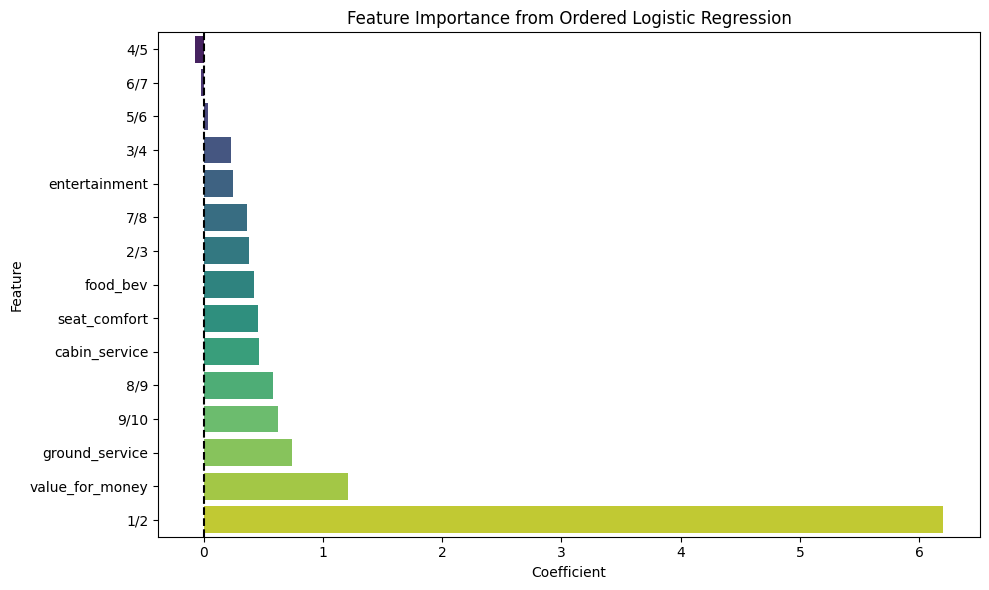

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract coefficients
coefficients = result.params
coefficients = coefficients.sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients.values, y=coefficients.index, palette="viridis")
plt.title("Feature Importance from Ordered Logistic Regression")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

## Pooling vs. No Pooling: A Comparison

### What Is "Pooling"?

"Pooling" refers to transforming the data from **wide format** (one row per customer with separate columns for each aspect rating) to **long format** (multiple rows per customer, one for each question type and its rating).

#### Example of Wide Format:
| seat_comfort | food_bev | entertainment | value_for_money | overall |
|--------------|----------|---------------|------------------|---------|
| 4            | 3        | 2             | 5                | 7       |

#### Example of Long (Pooled) Format:
| Question_ID     | rating | overall |
|------------------|--------|---------|
| seat_comfort     | 4      | 7       |
| food_bev         | 3      | 7       |
| entertainment    | 2      | 7       |
| value_for_money  | 5      | 7       |


## ✅ Pros of Pooling

| Benefit | Description |
|--------|-------------|
| **More granular analysis** | Lets you analyze how each question type influences satisfaction independently |
| **Easier to model interactions** | You can fit models that let the impact of ratings vary by question type |
| **Better for feature importance** | Easier to see which types of questions most strongly influence overall score |


## ⚠️ Cons of Pooling

| Limitation | Description |
|-----------|-------------|
| **Loss of independence** | Multiple rows share the same `overall` score → violates assumption of independent observations |
| **Increased noise** | May reduce predictive performance due to repeated patterns |
| **Harder to predict exact ratings** | The model sees only one question at a time, not the full context |


## ✅ Pros of Not Pooling (Wide Format)

| Benefit | Description |
|--------|-------------|
| **Full context per customer** | Each row contains all aspect ratings for one customer |
| **Independent observations** | Better statistical validity and easier interpretation |
| **Higher predictive accuracy** | Models often perform better when they see the full picture |


## ⚠️ Cons of Not Pooling

| Limitation | Description |
|-----------|-------------|
| **Less flexibility** | Harder to model how different question types affect satisfaction differently |
| **Requires more complex modeling** | Feature interactions are less direct to explore |


## 🧪 Which Approach Performed Better?

| Metric | Pooled Format | Wide Format |
|--------|----------------|-------------|
| **Accuracy** | ~48% | **~51%** ✅ |
| **RMSE** | ~1.68 | **~1.33** ✅ |
| **Kappa (quadratic)** | ~0.37 | **~0.945** ✅✅✅ |

> ✅ **Conclusion**:  
Using the **wide format (no pooling)** gave significantly better results — especially in terms of **Cohen’s Kappa**, which is a strong indicator of agreement between predicted and actual ratings.


## Recommendation

- Use **wide format** if your goal is to **predict customer satisfaction accurately**
- Use **pooled format** if your goal is to **understand which types of questions most strongly influence satisfaction**

You can even use **both approaches together**:
- Use wide format for prediction
- Use pooled format for insights and reporting

In [25]:
def predict_overall(model, seat_comfort, cabin_service, food_bev,
                    entertainment, ground_service, value_for_money):

    # Create DataFrame in wide format (one row with all features)
    X_new = pd.DataFrame({
        'seat_comfort': [seat_comfort],
        'cabin_service': [cabin_service],
        'food_bev': [food_bev],
        'entertainment': [entertainment],
        'ground_service': [ground_service],
        'value_for_money': [value_for_money]
    })

    # Predict probabilities
    predicted_probs = model.predict(X_new)

    # Compute expected rating
    expected_rating = np.sum(np.arange(1, 11) * predicted_probs.values[0])

    return round(expected_rating, 2)

In [26]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Assume df is your wide-format DataFrame
X = cleaned_df[['seat_comfort', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'cabin_service']]
y = cleaned_df['overall'].astype(int)

# Fit model
model_wide = OrderedModel(
    y,
    X,
    distr='logit'
)

result_wide = model_wide.fit(method='bfgs')  # result_wide is now your model

Optimization terminated successfully.
         Current function value: 1.216682
         Iterations: 42
         Function evaluations: 44
         Gradient evaluations: 44


In [27]:
print(predict_overall(
    model=result_wide,
    seat_comfort=4,
    cabin_service=5,
    food_bev=9,
    entertainment=4,
    ground_service=7,
    value_for_money=2
))

9.8


In [28]:
def explain_experience(model, seat_comfort, cabin_service, food_bev,
                       entertainment, ground_service, value_for_money):

    # Step 1: Predict probabilities (optional)
    X_new = pd.DataFrame({
        'seat_comfort': [seat_comfort],
        'cabin_service': [cabin_service],
        'food_bev': [food_bev],
        'entertainment': [entertainment],
        'ground_service': [ground_service],
        'value_for_money': [value_for_money]
    })

    # Optional: Predict expected rating (if needed later)
    predicted_probs = model.predict(X_new)
    expected_rating = np.sum(np.arange(1, 11) * predicted_probs.values[0])
    expected_rating = round(expected_rating, 2)

    # Step 2: Find highest and lowest rated aspects
    question_ratings = {
        'Seat Comfort': seat_comfort,
        'Cabin Service': cabin_service,
        'Food & Beverage': food_bev,
        'Entertainment': entertainment,
        'Ground Service': ground_service,
        'Value for Money': value_for_money
    }

    highest_aspect = max(question_ratings, key=question_ratings.get)
    lowest_aspect = min(question_ratings, key=question_ratings.get)

    # Step 3: Run LLM chain
    inputs = {
        "seat": seat_comfort,
        "cabin": cabin_service,
        "food": food_bev,
        "entertainment": entertainment,
        "ground": ground_service,
        "value": value_for_money
    }

    result_text = chain.invoke(inputs)
    return expected_rating, result_text

In [29]:
!pip install langchain-huggingface
!pip install langchain-community
!pip install huggingface_hub
!pip install transformers
!pip install accelerate
!pip install bitsandbytes
!pip install langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [31]:
from google.colab import userdata
sec_key = userdata.get('HF_token')

In [32]:
import os
os.environ["HUGGINGFACEHUB_API_TOKEN"] = sec_key

In [33]:
from langchain_huggingface import HuggingFaceEndpoint
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# Import secret key from Colab userdata
from google.colab import userdata
sec_key = userdata.get('HF_token')

# Set token in environment (optional, but good for compatibility)
import os
os.environ["HUGGINGFACEHUB_API_TOKEN"] = sec_key

# Define the model ID
repo_id = "HuggingFaceH4/zephyr-7b-beta"

# Initialize LLM using HuggingFaceEndpoint
llm = HuggingFaceEndpoint(
    repo_id=repo_id,
    task="text-generation",
    max_new_tokens=500,
    temperature=0.7,
    top_p=0.9,
    huggingfacehub_api_token=sec_key
)

prompt = PromptTemplate.from_template("""
You are an airline review analyst who interprets both raw customer ratings and data-driven insights from statistical models.

Below are the customer's ratings (scale: 1 = very poor, 5 = excellent):

Customer Ratings:
Seat Comfort: {seat}
Cabin Service: {cabin}
Food & Beverage: {food}
Entertainment: {entertainment}
Ground Service: {ground}
Value for Money: {value}

Key Statistical Insights:
- Value for Money and Seat Comfort have **increasing importance at higher ratings** — they strongly lift overall satisfaction when rated well.
- Entertainment has **diminishing returns** — even if rated highly, it does **not strongly improve** the overall perception.
- Food & Beverage becomes **more influential when rated highly** — improving this can meaningfully boost satisfaction.
- Ground Service has **minimal impact** on overall perception.

⚠️ Important Reminder for Analysis:
When rating aspects like Value for Money or Seat Comfort highly, emphasize their disproportionate effect on overall satisfaction.
When rating Entertainment highly, note that its influence is limited due to diminishing returns.

Instructions:
1. Start with a concise overall impression of the flight experience.
2. Identify the best and worst-rated aspects.
3. Briefly explain how these align with statistical insights.
4. End with a short recommendation based on regression findings.

Now provide a clear, concise explanation in 3–4 short paragraphs:
""")

# Build the chain using new syntax (LangChain v0.2+)
chain = prompt | llm

In [34]:
def add_recommendation(explanation, seat, value):
    # Identify which key drivers were low
    issues = []
    if seat < 3:
        issues.append("Seat Comfort")
    if value < 3:
        issues.append("Value for Money")

    if not issues:
        return explanation

    rec_block = "\n\n💡 **Recommendation:**\n"
    rec_block += "To significantly improve future satisfaction, focus on:\n"
    if "Seat Comfort" in issues:
        rec_block += "- Enhancing seating comfort (e.g., legroom, cushioning)\n"
    if "Value for Money" in issues:
        rec_block += "- Reassess pricing vs. service quality to improve perceived value\n"
    rec_block += "- Minor improvements in food/beverage could also help"

    return explanation + rec_block

In [35]:
# Define input ratings
input_ratings = {
    'seat_comfort': 4,
    'cabin_service': 5,
    'food_bev': 1,
    'entertainment': 4,
    'ground_service': 5,
    'value_for_money': 3
}

# Run prediction + explanation
expected_rating, explanation = explain_experience(model=result_wide, **input_ratings)

# Add dynamic recommendation
final_explanation = add_recommendation(
    explanation,
    seat=input_ratings['seat_comfort'],
    value=input_ratings['value_for_money']
)

# Print result
print("Expected Rating:", expected_rating)
print("Explanation:\n", final_explanation)

Expected Rating: 8.17
Explanation:
 
Overall, this flight experience was satisfactory, with high ratings for cabin service, ground service, and seat comfort. The customer's entertainment rating was also fairly high, but this aspect has diminishing returns, so its impact on overall satisfaction was limited. However, the low rating for food & beverage is a concern, as this factor becomes increasingly influential when rated highly. Improving the quality of food and beverages served could significantly boost overall satisfaction. Ground service had minimal impact on overall perception, but its rating was still high.

The findings from our statistical analysis support these ratings, with value for money and seat comfort having increasing importance at higher ratings. This means that these factors strongly lift overall satisfaction when rated well. Food & beverage, on the other hand, becomes more influential when rated highly, which is consistent with the customer's rating. While entertainme

## ✈️ **Airline Review Insight Generator**

*Using Machine Learning + LLMs to Explain and Improve Airline Experience*


### 🔧 What This Project Does

This system intelligently combines **statistical modeling** and **generative AI** to do more than just predict satisfaction scores — it explains *why* a customer felt a certain way and offers **tailored suggestions** for improvement.


### 🔁 Workflow Overview

```
Step 1: Customer provides individual ratings (1–5) for:
         - Seat Comfort
         - Cabin Service
         - Food & Beverage
         - Entertainment
         - Ground Service
         - Value for Money

Step 2: The system uses an Ordinal Logistic Regression model
        to predict the overall satisfaction score (1–10).

Step 3: It computes the expected rating as a weighted average
        of probabilities across all 10 possible satisfaction levels.

Step 4: It identifies the highest and lowest rated aspects from
        the customer's input.

Step 5: These insights (ratings + interpretation rules) are sent
        to a Large Language Model (Zephyr-7B via Hugging Face)
        using a structured LangChain prompt.

Step 6: The LLM generates a natural-language summary that:
         - Reflects the customer’s experience
         - Explains what worked and what didn’t
         - Aligns with statistical insights

Step 7: If Seat Comfort or Value for Money are low (<3),
        the system adds specific improvement tips to the explanation.

Step 8: The final result includes:
         ✅ A predicted overall rating
         💬 A personalized, data-informed explanation
         💡 Actionable recommendations
```


### 🧠 How Each Part Works

#### 1. **Ordinal Logistic Regression**

Trained using `statsmodels`, this model estimates how strongly each experience factor (e.g., food or service) influences overall satisfaction. Unlike linear regression, it understands **ranked outcomes** — perfect for predicting ratings on a scale (1 to 10).

#### 2. **Expected Rating**

Rather than predicting a single class, the model gives a probability for each satisfaction level (1–10). We multiply these by their respective scores and take the sum to get the **expected rating** — a more nuanced estimate.

#### 3. **Aspect Breakdown**

We highlight the **best** and **worst** rated features. This helps the explanation focus on what made the biggest positive and negative impressions on the customer.

#### 4. **AI Explanation via LangChain + Zephyr**

We craft a detailed prompt that combines:

* The customer’s individual scores
* Statistical insights (e.g., "Entertainment has diminishing returns")
* Contextual instructions

This prompt is sent to a language model which returns a **flight experience narrative** — similar to what a human analyst might write.

#### 5. **Dynamic Advice**

If key drivers like Seat Comfort or Value for Money are poor, we programmatically inject **custom recommendations** (e.g., improve legroom, reconsider pricing) into the final explanation.


### ✅ Outcome Example

> **Expected Rating:** 8.17

> **Explanation:** Overall, this flight experience was satisfactory, with high ratings for cabin service, ground service, and seat comfort. The customer's entertainment rating was also fairly high, but this aspect has diminishing returns, so its impact on overall satisfaction was limited. However, the low rating for food & beverage is a concern, as this factor becomes increasingly influential when rated highly. Improving the quality of food and beverages served could significantly boost overall satisfaction. Ground service had minimal impact on overall perception, but its rating was still high.
The findings from our statistical analysis support these ratings, with value for money and seat comfort having increasing importance at higher ratings. This means that these factors strongly lift overall satisfaction when rated well. Food & beverage, on the other hand, becomes more influential when rated highly, which is consistent with the customer's rating. While entertainment has diminishing returns, improving food & beverage quality could still make a meaningful difference to overall satisfaction.

> **Recommendation:** To improve the overall flight experience, we recommend focusing on enhancing food & beverage quality. This could involve working with chefs to create more appealing and high-quality menus, as well as investing in better equipment to prepare and serve food. By improving food & beverage quality, we can lift overall satisfaction and enhance customer loyalty.